In [1]:
!pip install torch==2.2.2
!pip install torchtext==0.17.2
!pip install portalocker==2.8.2
!pip install torchdata==0.7.1
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 136.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvtx-cu12
 

In [2]:
# Import all the necessary libraries

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import IterableWrapper, Mapper
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu
import torch
import torch.nn as nn
import torch.optim as optim


import numpy as np
import random
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

In [3]:
# Simulate the RNN with the formula

W_xh=torch.tensor(-10.0)
W_hh=torch.tensor(10.0)
b_h=torch.tensor(0.0)
x_t=1
h_prev=torch.tensor(-1)

X=[1,1,-1,-1,1,1]

H=[-1,-1,0,1,0,-1]

H_hat = []

t=1

for x in X:
    print("t=",t)
    x_t = x
    print("h_t-1", h_prev.item())

    h_t = torch.tanh(x_t * W_xh + h_prev * W_hh + b_h)
    h_prev = h_t

    print("x_t", x_t)

    print("h_t", h_t.item())
    print("\n")

    H_hat.append(int(h_t.item()))
    t+=1

t= 1
h_t-1 -1
x_t 1
h_t -1.0


t= 2
h_t-1 -1.0
x_t 1
h_t -1.0


t= 3
h_t-1 -1.0
x_t -1
h_t 0.0


t= 4
h_t-1 0.0
x_t -1
h_t 1.0


t= 5
h_t-1 1.0
x_t 1
h_t 0.0


t= 6
h_t-1 0.0
x_t 1
h_t -1.0




In [4]:
H_hat
H

[-1, -1, 0, 1, 0, -1]

In [5]:
# Encoder class

class Encoder(nn.Module):
    def __init__(self, vocab_len, emb_dim, hid_dim, n_layers, dropout_prob):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_len, emb_dim)

        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        embed = self.dropout(self.embedding(input_batch))
        embed = embed.to(device)
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell

In [6]:
# Encoder configurations

vocab_len = 8
emb_dim = 10
hid_dim=8
n_layers=1
dropout_prob=0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initiate encoder

encoder_t = Encoder(vocab_len, emb_dim, hid_dim, n_layers, dropout_prob).to(device)

In [7]:
# Test the encoder

src_batch = torch.tensor([[0,3,4,2,1]])
src_batch = src_batch.t().to(device)
print("Shape of input(src) tensor:", src_batch.shape)
hidden_t , cell_t = encoder_t(src_batch)
print("Hidden tensor from encoder:",hidden_t ,"\nCell tensor from encoder:", cell_t)

Shape of input(src) tensor: torch.Size([5, 1])
Hidden tensor from encoder: tensor([[[-0.2777,  0.1078, -0.2467,  0.0577, -0.0516,  0.1223, -0.1745,
           0.0195]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>) 
Cell tensor from encoder: tensor([[[-0.6262,  0.2986, -0.4202,  0.0859, -0.0984,  0.2013, -0.3938,
           0.0224]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)


In [8]:
# Decoder class

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers


        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction_logit = self.fc_out(output.squeeze(0))
        prediction = self.softmax(prediction_logit)


        return prediction, hidden, cell

In [9]:
# Decoder configurations

output_dim = 6
emb_dim=10
hid_dim = 8
n_layers=1
dropout=0.5

# Initiate decoder

decoder_t = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)

In [10]:
# Test the decoder

input_t = torch.tensor([0]).to(device) #<bos>
input_t.shape
prediction, hidden, cell = decoder_t(input_t, hidden_t , cell_t)
print("Prediction:", prediction, '\nHidden:',hidden,'\nCell:', cell)

Prediction: tensor([[-1.6983, -1.5038, -2.0386, -2.1167, -1.7580, -1.7619]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>) 
Hidden: tensor([[[-0.4743,  0.0360,  0.0474,  0.2197,  0.0937, -0.1430, -0.1490,
          -0.0638]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>) 
Cell: tensor([[[-0.9950,  0.0728,  0.0806,  0.3457,  0.1231, -0.2291, -0.3009,
          -0.1099]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)


In [11]:
# Pass the encoder's hidden and cell into decoder and check the decoder's outputs and its shape

teacher_forcing_ratio = 0.5
trg = torch.tensor([[0],[2],[3],[5],[1]]).to(device)

batch_size = trg.shape[1]
trg_len = trg.shape[0]
trg_vocab_size = decoder_t.output_dim
outputs_t = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)

hidden_t = hidden_t.to(device)
cell_t = cell_t.to(device)

input = trg[0,:]

for t in range(1, trg_len):
    output_t, hidden_t, cell_t = decoder_t(input, hidden_t, cell_t)

    outputs_t[t] = output_t

    teacher_force = random.random() < teacher_forcing_ratio

    top1 = output_t.argmax(1)

    input = trg[t] if teacher_force else top1

print(outputs_t,outputs_t.shape )

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.7562, -1.4794, -2.0214, -2.0305, -1.7530, -1.8169]],

        [[-1.8117, -1.4896, -2.0338, -1.8951, -1.7737, -1.8306]],

        [[-1.8184, -1.4667, -2.1151, -1.9327, -1.8099, -1.7261]],

        [[-1.8990, -1.5319, -2.0413, -1.8180, -1.7727, -1.7599]]],
       device='cuda:0', grad_fn=<CopySlices>) torch.Size([5, 1, 6])


In [12]:
# Check the decoder's predicted tokens

pred_tokens = outputs_t.argmax(2)
print(pred_tokens)

tensor([[0],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


In [13]:
# Combine encoder and decoder to build the full Seq2Seq model

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device,trg_vocab):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.trg_vocab = trg_vocab

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):


        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        hidden = hidden.to(device)
        cell = cell.to(device)

        input = trg[0,:]

        for t in range(1, trg_len):

            output, hidden, cell = self.decoder(input, hidden, cell)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs

In [14]:
# Function to train the Seq2Seq model

def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    train_iterator = tqdm(iterator, desc="Training", leave=False)

    for i, (src,trg) in enumerate(iterator):

        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)

        trg = trg[1:].contiguous().view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        train_iterator.set_postfix(loss=loss.item())

        epoch_loss += loss.item()

    return epoch_loss / len(list(iterator))

In [15]:
# Function to evaluate the Seq2Seq model

def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    valid_iterator = tqdm(iterator, desc="Training", leave=False)

    with torch.no_grad():

        for i, (src,trg) in enumerate(iterator):

            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)

            trg = trg[1:].contiguous().view(-1)

            loss = criterion(output, trg)
            valid_iterator.set_postfix(loss=loss.item())

            epoch_loss += loss.item()

    return epoch_loss / len(list(iterator))

In [16]:
# Load the python script to get pre written code

!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py'

--2025-12-17 01:30:01--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4890 (4.8K) [application/x-python]
Saving to: ‘Multi30K_de_en_dataloader.py’

Multi30K_de_en_data 100%[===================>]   4.78K  --.-KB/s    in 0s      

2025-12-17 01:30:02 (1.90 GB/s) - ‘Multi30K_de_en_dataloader.py’ saved [4890/4890]



In [17]:
# Run the loaded python script

%run Multi30K_de_en_dataloader.py

In [40]:
# Create training and validation dataloaders

train_dataloader, valid_dataloader = get_translation_dataloaders(batch_size = 4, flip=True)

In [41]:
# Check the first batch of the dataloader

src, trg = next(iter(train_dataloader))
src,trg

(tensor([[    2,     2,     2,     2],
         [    3,  5510,  5510,  1701],
         [    1,     3,     3,     8],
         [    1,     1,     1, 12642],
         [    1,     1,     1,     3]], device='cuda:0'),
 tensor([[   2,    2,    2,    2],
         [   3, 6650,  216,    6],
         [   1, 4623,  110, 3398],
         [   1,  259, 3913,  202],
         [   1,  172, 1650,  109],
         [   1, 9953, 3823,   37],
         [   1,  115,   71,    3],
         [   1,  692, 2808,    1],
         [   1, 3428, 2187,    1],
         [   1,    5,    5,    1],
         [   1,    3,    3,    1]], device='cuda:0'))

In [42]:
# Check 3 batches of source and target sentences

data_itr = iter(train_dataloader)

for n in range(1000):
    german, english= next(data_itr)

for n in range(3):
    german, english=next(data_itr)
    german=german.T
    english=english.T
    print("________________")
    print("german")
    for g in german:
        print(index_to_german(g))
    print("________________")
    print("english")
    for e in english:
        print(index_to_eng(e))

________________
german
<bos> . Innenstadt der in Hüten schwarzen mit Personen <eos>
<bos> . Stadt einer in protestiert Menschen Gruppe Eine <eos>
<bos> . mit Ansichten politischen ihre teilt Gruppe Eine <eos>
<bos> . Strand felsigen einem an sitzen Personen Mehrere <eos>
________________
english
<bos> People in black hats gathered together downtown . <eos> <pad> <pad> <pad>
<bos> A group of people protesting in a city . <eos> <pad> <pad>
<bos> A group is letting their political opinion be known . <eos> <pad>
<bos> A group of people are sitting on a rocky beach . <eos>
________________
german
<bos> . Sonnenbrillen und Hüten mit Personen sitzende Zwei <eos>
<bos> . Angeln beim Hut mit Junge kleiner Ein <eos>
<bos> . Giorgio's im Spaß haben Frauen zwei Diese <eos>
<bos> . Sofa dem auf schlafen Kinder kleine Zwei <eos>
________________
english
<bos> Two people sitting in hats and shades . <eos> <pad> <pad> <pad>
<bos> A young boy in a hat is fishing by himself . <eos>
<bos> These two wome

In [43]:
# Setting seeds for reproducibility

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [44]:
# Set model configurations

INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

# Initiate encoder and decoder

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# Initiate the Seq2Seq model

model = Seq2Seq(enc, dec, device,trg_vocab = vocab_transform['en']).to(device)

In [45]:
# Function to initiate weights in model layers

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19214, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10837, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (fc_out): Linear(in_features=256, out_features=10837, bias=True)
    (softmax): LogSoftmax(dim=1)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (trg_vocab): Vocab()
)

In [46]:
# Function to how many parameters the model has

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,422,165 trainable parameters


In [47]:
# Set optimizer, pad index and criterion for the model

optimizer = optim.Adam(model.parameters())

PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [48]:
# Function to check how long the training took for one epoch

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [49]:
# Training and evaluating the Seq2Seq model

torch.cuda.empty_cache()

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')
best_train_loss = float('inf')
train_losses = []
valid_losses = []

train_PPLs = []
valid_PPLs = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    train_ppl = math.exp(train_loss)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    valid_ppl = math.exp(valid_loss)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN-TR-model.pt')

    train_losses.append(train_loss)
    train_PPLs.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_PPLs.append(valid_ppl)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

Epoch: 01 | Time: 3m 14s
	Train Loss: 4.398 | Train PPL:  81.263
	 Val. Loss: 5.174 |  Val. PPL: 176.553


Epoch: 02 | Time: 3m 14s
	Train Loss: 3.640 | Train PPL:  38.092
	 Val. Loss: 4.808 |  Val. PPL: 122.521


Epoch: 03 | Time: 3m 16s
	Train Loss: 3.256 | Train PPL:  25.957
	 Val. Loss: 4.457 |  Val. PPL:  86.259


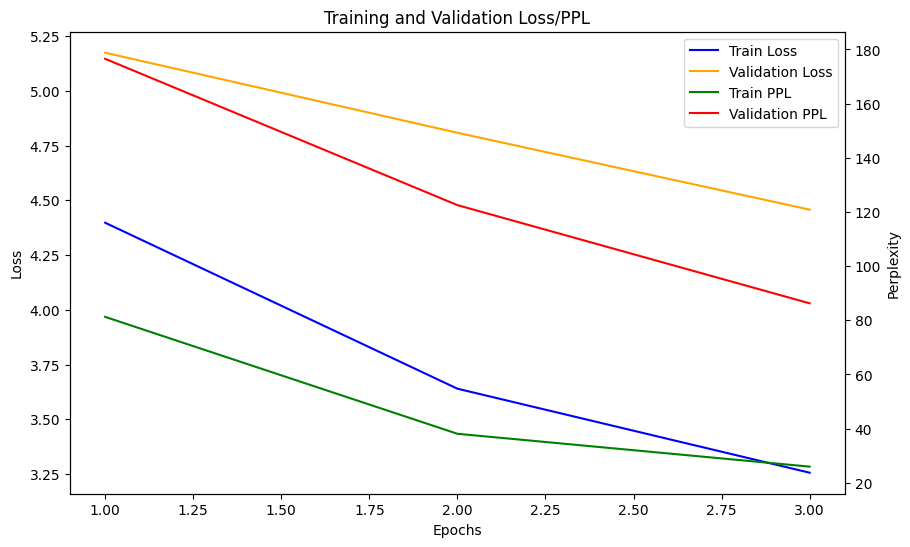

In [50]:
# Visualize the training and validation loss and perplexity scores

import matplotlib.pyplot as plt

epochs = [epoch+1 for epoch in range(N_EPOCHS)]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss/PPL')

ax2.plot(epochs, train_PPLs, label='Train PPL', color='green')
ax2.plot(epochs, valid_PPLs, label='Validation PPL', color='red')
ax2.set_ylabel('Perplexity')

ax2.set_ylim(bottom=min(min(train_PPLs), min(valid_PPLs)) - 10, top=max(max(train_PPLs), max(valid_PPLs)) + 10)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

plt.show()

In [51]:
# Load the trained weights into the model

model.load_state_dict(torch.load('RNN-TR-model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [52]:
# Function to use the trained model to make translations

import torch.nn.functional as F

def generate_translation(model, src_sentence, src_vocab, trg_vocab, max_len=50):

    with torch.no_grad():
        src_tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(device)

        hidden, cell = model.encoder(src_tensor)

        trg_indexes = [trg_vocab.get_stoi()['<bos>']]

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)

        trg_tensor = trg_tensor.to(model.device)

        for _ in range(max_len):

            output, hidden, cell = model.decoder(trg_tensor[-1], hidden, cell)

            pred_token = output.argmax(1)[-1].item()

            trg_indexes.append(pred_token)

            if pred_token == trg_vocab.get_stoi()['<eos>']:
                break

            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)

            trg_tensor = trg_tensor.to(model.device)

        trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes]

        if trg_tokens[0] == '<bos>':
            trg_tokens = trg_tokens[1:]
        if trg_tokens[-1] == '<eos>':
            trg_tokens = trg_tokens[:-1]

        translation = " ".join(trg_tokens)

        return translation

In [53]:
# Test the model translation on a sentence

src_sentence = 'Ein asiatischer Mann kehrt den Gehweg.'

generated_translation = generate_translation(model, src_sentence=src_sentence, src_vocab=vocab_transform['de'], trg_vocab=vocab_transform['en'], max_len=12)
print(generated_translation)

An Asian man is on the sidewalk of a building .


In [54]:
# Function to calculate BLEU score

def calculate_bleu_score(generated_translation, reference_translations):
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

In [55]:
# Create reference translations and calculate BLEU score on the model translation

reference_translations = [
    "Asian man sweeping the walkway .",
    "An asian man sweeping the walkway .",
    "An Asian man sweeps the sidewalk .",
    "An Asian man is sweeping the sidewalk .",
    "An asian man is sweeping the walkway .",
    "Asian man sweeping the sidewalk ."
]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score)

BLEU Score: 0.28997844147152074


In [56]:
# Test the model translation on another german text

german_text = "Menschen gehen auf der Straße"

english_translation = generate_translation(
    model,
    src_sentence=german_text,
    src_vocab=vocab_transform['de'],
    trg_vocab=vocab_transform['en'],
    max_len=50
)

print(f"Original German text: {german_text}")
print(f"Translated English text: {english_translation}")

Original German text: Menschen gehen auf der Straße
Translated English text: People walking down the street on a city street .
